In [1]:
# Integration of biopsies and organ donors from 2 studies
import anndata, numpy as np, pandas as pd, imp, scanpy as sc, rpy2
import matplotlib.pyplot as plt
imp.reload(lpy)
%load_ext rpy2.ipython
%matplotlib inline
sc.logging.print_header()
pd.options.display.max_columns = None
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
import lpy # local lpy.py file

scanpy==1.9.1 anndata==0.7.8 umap==0.4.6 numpy==1.19.5 scipy==1.6.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [2]:
adata = anndata.read_h5ad("int5.h5ad")

Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


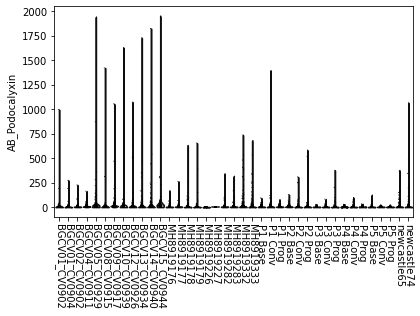

In [3]:
flt = (adata.obs["StudyName"] != "China")&([x in ["Tcell","Bcell","Monocytes"] for x in adata.obs["broad_integrated"]])
adata.obs["batch"] = [y if x == "Other" else x for x,y in  zip(adata.obs["CVID_Series"], adata.obs["sample_names"])]
sc.pl.violin(adata[flt], ["AB_Podocalyxin"],groupby="batch",rotation=-90,use_raw=True)

In [4]:
import re
celltype_key = "general_integrated2"
filter = np.array(adata.obs["StudyName"] == "Javi")&(np.array(adata.obs[celltype_key] != "filtered"))&(np.array(adata.obs["Stage"] != "convalescence") )

#DEcalcIntersection(sce,  "general_integrated2", use.meta.as.replicate="patientID" , meta.pos = list(Stage= "progression"), meta.use = list(Stage= c("baseline","progression"), StudyName= "Javi" ))
adatasub = adata[filter]

df_meta = pd.DataFrame(data={'Cell':[i for i in adatasub.obs.index], 'cell_type':[ re.sub(" ", "_",i ) for i in adatasub.obs[celltype_key]]})
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('CellPhoneDb_meta.tsv', sep = '\t')
adatasub.write_h5ad('Cellphone_subset.h5ad')
df_meta['cell_type'].value_counts()

NKT-like                   7160
TE_CD8                     5555
Classical_monocytes        3669
T_Effector_CD4             2729
Tcell_Cycling              2314
Cytotoxic_T_cell           2075
TEM_CD8                    1773
TCM_CD4                    1741
Intermediate_monocytes     1735
Bcell_naive                1201
Non-classical_monocytes    1179
NK_CD16                     899
Cl._mono_IFN                793
NK_CD56                     610
T_Naive_CD4                 573
Cl._mono_inflammasome       483
Bcell_US-mem                372
Cl._mono_S100A8             335
gdT                         248
pDC                         245
TEM_CD4                     230
cDCs                        203
T_Naive_CD8                 180
Treg                        133
Platelets                   126
hSC                          97
dnT                          65
MAIT                         47
Bcell_S-mem                  32
ASDC                          7
Erythrocytes                  3
Plasma_B

In [5]:
%%R
res <- readRDS("../../W1.rds")

concat = c()
for(i in names(res$signifDE)[grep("TOP_",names(res$signifDE))]) {
    tmp <- res$signifDE[[i]];
    tmp[["Cluster"]] <- sub("TOP_","",i);
    tmp[["Gene"]] = rownames(tmp);
    if (is.null(concat)) concat <- tmp
    else concat <- rbind(concat,tmp)
}

moddf = concat[ c("Cluster", "Gene", "wilcox.logitAuroc", "wilcox.log10pval" ,"Corrected_wilcox.log10pval", "meanTPM", "dropoutPosClass", "dropoutNegClass") ]                                                
write.table(moddf, "CellPhoneDb_degs.tsv", quote = F, sep = "\t", row.names = F)
print(table(moddf["Cluster"]))

#fDEGs = fDEGs[['cluster', 'gene', 'p_val_adj', 'p_val', 'avg_log2FC', 'pct.1', 'pct.2']] 
#fDEGs.to_csv('endometrium_example_DEGs.tsv', index=False, sep='\t')


            Bcell_naive             Bcell_S-mem            Bcell_US-mem 
                   3166                     127                    1398 
                   cDCs            Cl._mono_IFN   Cl._mono_inflammasome 
                   1448                    2445                    3973 
        Cl._mono_S100A8     Classical_monocytes        Cytotoxic_T_cell 
                   1299                    3370                    3157 
                    dnT                filtered                     gdT 
                    749                    8174                     558 
                    hSC  Intermediate_monocytes                    MAIT 
                    473                    6176                      89 
                NK_CD16                 NK_CD56                NKT-like 
                   1677                    2692                    3542 
Non-classical_monocytes                     pDC               Platelets 
                   5072                    2211   

In [6]:
%%bash
cellphonedb method degs_analysis CellPhoneDb_meta.tsv Cellphone_subset.h5ad CellPhoneDb_degs.tsv \
    --counts-data hgnc_symbol



[ ][APP][09/12/21-23:38:36][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][09/12/21-23:38:36][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][09/12/21-23:38:36][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][09/12/21-23:38:36][INFO] Using custom database at /home/jovyan/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][09/12/21-23:38:37][INFO] Launching Method cpdb_degs_analysis_local_method_launcher
[ ][APP][09/12/21-23:38:37][INFO] Launching Method _set_paths
[ ][APP][09/12/21-23:38:37][WARNING] Output directory (/lustre/scratch117/cellgen/team292/lh20/1gpunobooks/javi/out) exist and is not empty. Result can overwrite old results
[ ][APP][09/12/21-23:38:37][INFO] Launching Method _load_meta_counts
[ ][APP][09/12/21-23:38:53][INFO] Launching Method _check_counts_data
[ ][APP][09/12/21-23:38:53][INFO] Launching Method _load_degs
[ ][APP][09/12/21-23:38:53][ERROR] Unexpected error
Traceback (most recent call last):
  File 

In [7]:
mmm =  pd.read_csv("out/significant_means.txt", sep='\t')
mmm

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,pDC|T_Naive_CD4,pDC|T_Naive_CD8,pDC|Tcell_Cycling,pDC|Treg,pDC|cDCs,pDC|dnT,pDC|filtered,pDC|gdT,pDC|hSC,pDC|pDC
0,CPI-SS00046DCF3,EPHA4_EFNB1,simple:P54764,simple:P98172,EPHA4,EFNB1,False,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPI-SS0470AF83E,EPHB1_EFNB1,simple:P54762,simple:P98172,EPHB1,EFNB1,False,True,False,curated,...,NaN,NaN,NaN,NaN,0.307,NaN,NaN,NaN,NaN,NaN
2,CPI-SS0111AAD26,EPHB2_EFNB1,simple:P29323,simple:P98172,EPHB2,EFNB1,False,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPI-SS0DC4D593E,EPHB6_EFNB1,simple:O15197,simple:P98172,EPHB6,EFNB1,True,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SS0D37C7C70,DLK1_NOTCH4,simple:P80370,simple:Q99466,DLK1,NOTCH4,False,False,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,CPI-CS0700FDD27,BMPR1B_BMPR2_GDF5,complex:BMPR1B_BMPR2,simple:P43026,NaN,GDF5,True,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,CPI-CS0DAA66443,BMR1A_ACR2A_GDF5,complex:BMR1A_ACR2A,simple:P43026,NaN,GDF5,True,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1121,CPI-CS036BF2AC7,BMR1A_AVR2B_GDF5,complex:BMR1A_AVR2B,simple:P43026,NaN,GDF5,True,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,CPI-CS075442484,BMR1A_ACR2A_BMP2,complex:BMR1A_ACR2A,simple:P12643,NaN,BMP2,True,True,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.001 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0 # min logFC to consider a gene as DEG

array([[[2.400e+02, 3.950e+02, 1.690e+02, ..., 1.300e+02, 5.300e+02,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [3.000e+00, 8.000e+00, 2.100e+01, ..., 9.000e+01, 7.300e+01,
         0.000e+00],
        [2.000e+00, 1.778e+03, 4.820e+02, ..., 6.700e+01, 2.500e+01,
         0.000e+00],
        [1.000e+00, 0.000e+00, 4.000e+00, ..., 0.000e+00, 8.000e+00,
         0.000e+00]],

       [[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         2.950e+02],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
   

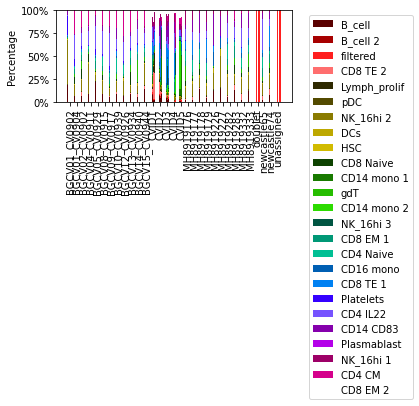

In [9]:
lpy.makeBarplot(adata.obs[adata.obs["StudyName"] != "China"], "leiden_sampl_Hani", "demultiplexed", "Stage", color = adata.uns["leiden_sampl_Hani_colors"] )

In [10]:
genometa = pd.read_csv("genotype.tsv",sep='\t')
pd.set_option('max_rows', 700)
print(adata.obs["demultiplexed"].value_counts())
adata = lpy.addMetadata(adata, genometa, "demultiplexed", "Patients", column_list= ["Age", "Sex","SARS-CoV-2", "Comorbidities", "Medication"])


CVID1            58583
CVID2            26579
CVID3            19424
MH8919333        11970
S-M044           11384
doublet          11224
S-HC015          10771
S-HC013          10477
S-HC017          10065
S-M067            9952
S-HC014           8393
S-S065            8129
MH8919332         7850
CVID4             7137
MH8919178         6948
newcastle74       6850
BGCV01_CV0904     6847
MH8919282         6802
MH8919283         6642
S-S054            5763
newcastle65       5604
S-S067            5592
S-S068            5298
S-HC010           5138
S-S055            5103
S-M051            5096
S-M052            4987
S-S057            4544
CVID5             4251
S-M046            4235
MH8919179         4214
S-M047            4172
S-M055            4117
S-M050            3821
S-S059            3772
S-HC008           3673
BGCV13_CV0934     3408
MH8919176         3085
BGCV14_CV0940     2957
BGCV09_CV0917     2923
S-S062            2884
S-S061            2861
BGCV12_CV0926     2620
BGCV02_CV09

[ 50 100 100  25  25 100]
nbCells
n_genes
log2p1_count
Sex
Age
Stage


<AxesSubplot:>

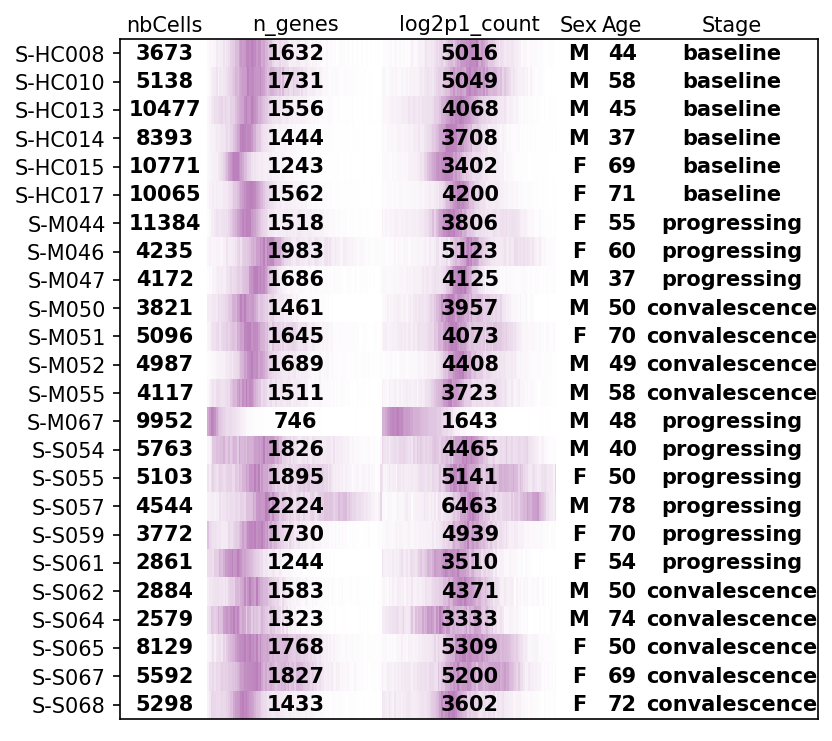

In [11]:
lpy.makeDensityHeatmap(adata.obs[adata.obs["StudyName"] == "China"], "demultiplexed", ["nbCells", "n_genes", "log2p1_count", "Sex", "Age", "Stage"],overwrite_dico = {},
                        width_dico={"Sex":25,"Age":25, "Stage": 100}, 
                        scaledisplay= [{"format" : ".0f"},{"format" : ".0f"},{"format" : ".0f","scale" : "exp2"},{"format" : ".0f"},{"format" : ".0f"},{"format" : ".0f"}])

In [12]:
adata.obs["Stage"][adata.obs["StudyName"] == "Haniffa"] = "baseline"

In [13]:
adata.obs[adata.obs["StudyName"] == "China"]

,souporcell,demultiplexed,sample_names,log2p1_count,percent_mito,n_genes,batch,full_clustering,initial_clustering,patient_id,...,filtered_cells,S_score,G2M_score,phase,leiden_sampl_Hani,leidenres2_sampl_Hani,leiden_sampl_China,leidenres2_sampl_China,VDJ_type,clonotype
S-HC008_AAACCTGCAAAGGAAG-30,singlet,S-HC008,S-HC008,12.218866,0.041964,1433,10,,,,...,False,-0.083333,-0.204038,G1,filtered,filtered,CD4 Naive,9,NONE,None
S-HC008_AAACCTGCACCCTATC-30,singlet,S-HC008,S-HC008,12.424166,0.052047,1419,10,,,,...,False,-0.019841,-0.214027,G1,filtered,filtered,CD4 Naive,9,NONE,None
S-HC008_AAACCTGCACGTCAGC-30,singlet,S-HC008,S-HC008,11.643856,0.048765,1489,10,,,,...,False,-0.057540,-0.096829,G1,filtered,filtered,NK_16hi 2,1,NONE,None
S-HC008_AAACCTGCAGGATCGA-30,singlet,S-HC008,S-HC008,11.871521,0.036305,1300,10,,,,...,False,-0.053571,-0.157472,G1,filtered,filtered,CD4 IL22,4,NONE,None
S-HC008_AAACCTGCATCGGACC-30,singlet,S-HC008,S-HC008,12.575776,0.042923,1733,10,,,,...,False,-0.073413,-0.241753,G1,filtered,filtered,CD8 Naive,25,NONE,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S-S068_TTTGTCACACGGCTAC-43,singlet,S-S068,S-S068,11.643406,0.046279,1433,34,,,,...,False,-0.041667,-0.083890,G1,filtered,filtered,NK_16hi 2,12,NONE,None
S-S068_TTTGTCACAGGAATGC-43,singlet,S-S068,S-S068,11.764873,0.021270,1562,34,,,,...,False,-0.071429,-0.069458,G1,filtered,filtered,NK_16hi 3,12,NONE,None
S-S068_TTTGTCAGTCGTGGCT-43,singlet,S-S068,S-S068,11.314017,0.028291,1134,34,,,,...,False,-0.049603,-0.144177,G1,filtered,filtered,CD8 TE 2,6,NONE,None
S-S068_TTTGTCAGTGATGTGG-43,singlet,S-S068,S-S068,11.227015,0.049249,1052,34,,,,...,False,0.059524,-0.072444,S,filtered,filtered,CD8 TE 1,13,NONE,None


In [14]:
hanimark = ["CLEC9A","CADM1","CLEC10A","CD1C","CD14","VCAN","CCR7","LAMP3","AXL","SIGLEC6","LILRA4","ITM2C","GZMB","IL1B","IER3","LDLR","CD83","S100A12","CSF3R","FCGR3A","MS4A7",
"LILRB1","CSF1R","CDKN1C","C1QA","C1QB","C1QC","CCR1","MARCO","MKI67","TOP2A"]

hanimark2 = ["CD141","CLEC9A","KIT","BTLA","CD1C","CD101","FCER1a","CD5","CD123","CD45RA","CD304","CD14","CD99","CD64","CR1","ITGAM","CD16","C5AR1","CX3CR1"]
rqs_nkcell = ["NFKBIA","FOSB","IL1B","S100A8","S100A9","CD74","B2M","FTL","C1QA","C1QB","C1QC","IL16","CCL2","CCL8","CCL7","CCL4L2","CCL3","CCL4","CCL18","CXCL8","CXC16","CXCL10"]


adata2 = adata[adata.obs[adata.obs["StudyName"] == "Javi"] ]
sc.pl.dotplot(adata2, var_names= hanimark, groupby= "leiden_scvi16_nkcells_renamed", show=True, use_raw=False)

In [15]:
#adata.obs["leiden_sampl"] =  lpy.applyFactorRename(adata.obs["leiden_sampl"],dadico)
import re

adata.var.index = [re.sub("GRCh38___","",x) for x in adata.var.index]
adata.raw.var.index = [re.sub("GRCh38___","",x) for x in adata.raw.var.index]
#adata.raw.var_names = anndata.Anndata(data=adata.raw.X, var = tmp) 
#sc.pp.highly_variable_genes(adata, inplace= True)

In [16]:
%%R -o matx -o mati -o matp -o var -o obs
library("SingleCellExperiment")

sce <- readRDS("/lustre/scratch117/cellgen/team292/lh20/javi/covidchina.sce.rds")

matx = assays(sce)[[1]]@x
mati = assays(sce)[[1]]@i
matp = assays(sce)[[1]]@p
var = data.frame(rowData(sce))
obs = data.frame(colData(sce))
rm(sce)
sessionInfo()

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiff

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [3] Biobase_2.50.0              GenomicRanges_1.42.0       
 [5] GenomeInfoDb_1.26.4         IRanges_2.24.1             
 [7] S4Vectors_0.28.1            BiocGenerics_0.36.0        
 [9] MatrixGenerics_1.2.1        matrixStats_0.58.0 

In [17]:
tmp = scipy.sparse.csc_matrix( (matx, [damap[x] for x in mati], matp) ).tocsc()
del matx
del mati
del matp
copy = tmp.indptr[1:]
print(len(tmp.indptr))
print(len(copy))

copy += adata.raw.X.data.shape[0]

nmat = scipy.sparse.csr_matrix((np.concatenate((adata.raw.X.data,tmp.data), axis = 0)
, np.concatenate((adata.raw.X.indices,tmp.indices), axis = 0)
, np.concatenate((adata.raw.X.indptr,copy), axis = 0)), shape=(593613, 28928))
del tmp
del copy


504691
504690


In [18]:
adata2 = anndata.AnnData(nmat, var = svar, obs = pd.concat([adata.obs, obs], axis=1))


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
adata2.obs["sample_names"] = pd.Categorical([x if pd.isna(y) else y for x,y in zip(adata2.obs["sample_names"] , adata2.obs["sampleID"]) ])
del(adata2.obs["sampleID"])
adata2.obs["souporcell"] = pd.Categorical(["singlet" if pd.isna(x) else x for x in adata2.obs["souporcell"] ])


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
samplem = meta = pd.read_csv("../../javi/sample.tsv",sep='\t')

adata2 = lpy.addMetadata(adata2, samplem, "sample_names", "Sample name", doinspect=True)

Add metadata from sample table to anndata
def addMetadata(adata, metadata, obs_key, meta_key, column_list=None, doinspect=False):
    if doinspect is True: print("\033Add metadata from sample table to anndata\033\033"); print(inspect.getsource(addMetadata));print("\033Execution:\033")
    aslist = metadata[meta_key].tolist()
    rowmap = {i : aslist.index(i)  for i in aslist}

    if column_list is None: column_list = metadata.columns
    for val in column_list:
        if val != meta_key:
            aslist = metadata[val].tolist()
            adata.obs[val] = [aslist[rowmap[i]] for i in adata.obs[obs_key] ]
    return adata;

Execution:


In [21]:
adata2.obs['log2p1_count'] = pd.to_numeric(np.log1p(np.sum(adata2.X, axis=1).A1) / math.log(2), downcast='float')
adata2.obs['n_genes'] = np.sum(adata2.X != 0, axis=1).A1
is_mito_genes = [name.startswith("GRCh38___MT-") for name in adata2.var_names]
adata2.obs['percent_mito'] = pd.to_numeric(np.sum(adata2[:, is_mito_genes].X, axis=1).A1 / np.sum(adata2.X, axis=1).A1, downcast='float')

In [22]:
adatasub = adata2[ adata2.obs["filtered_cells"] == False]
adatasub.var_names_make_unique()
sc.pp.highly_variable_genes(
    adatasub,
    n_top_genes=5000,
    subset=True,
    flavor="seurat_v3"
)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


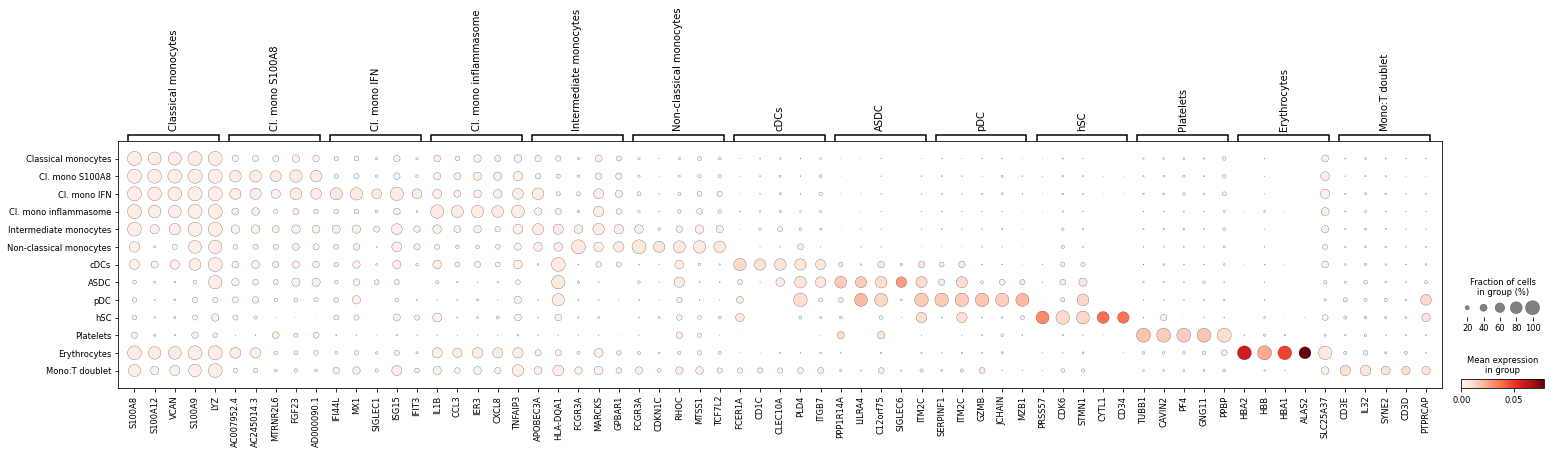

Trying to set attribute `._uns` of view, copying.


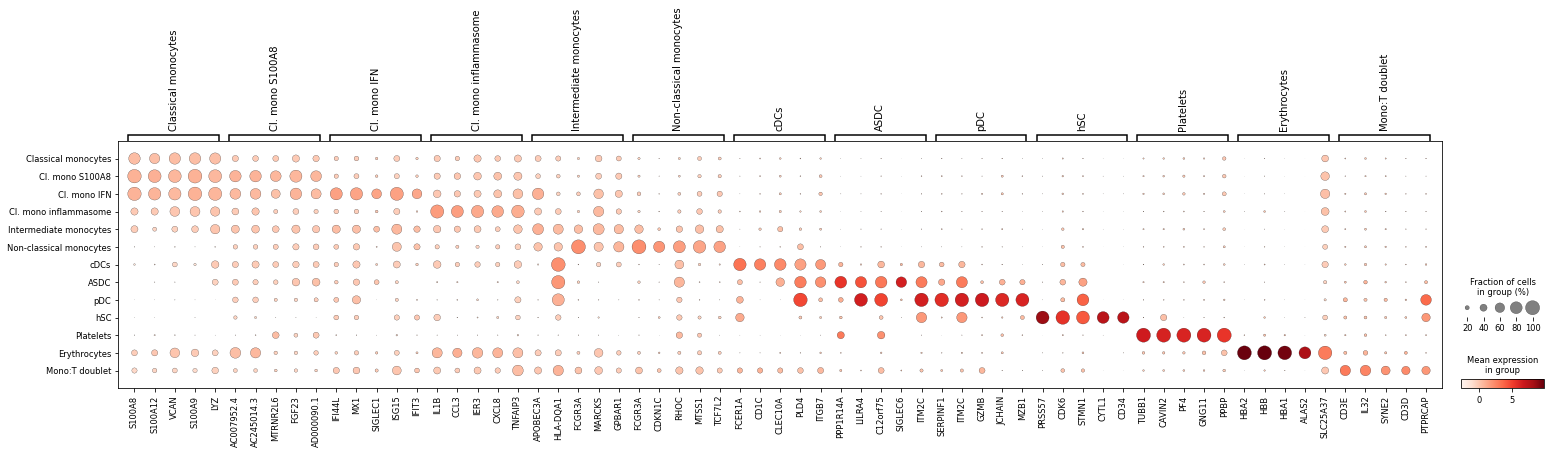

In [23]:
adatasub = adata[adata.obs["broad_integrated"] == "Monocytes"]
mmm = lpy.binarizedDE(adatasub,"general_integrated2",savepdf=None)

filtered down to 190389 cells


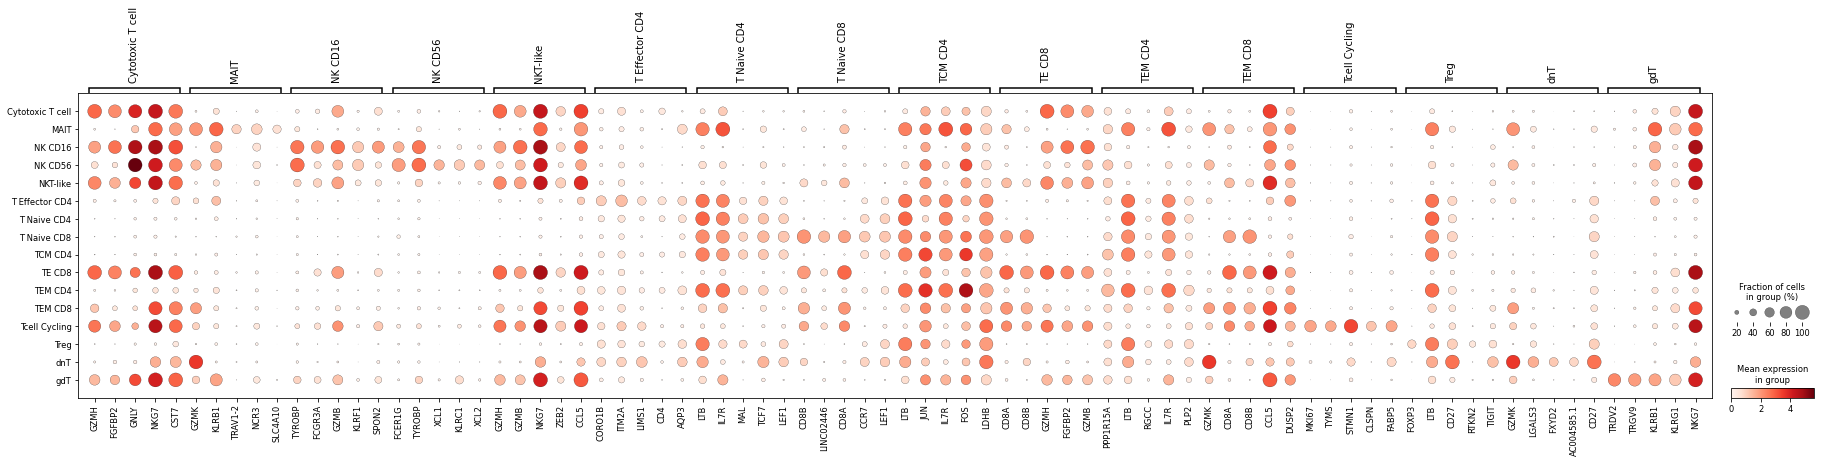

In [24]:
imp.reload(lpy)
annotation = ["general_integrated2","general_integrated2","general_integrated2","general_integrated2"]
manifold = ["X_umap_everything_unpool","X_umap_every_tcell20unpool","X_umap_every_bcell20unpool","X_umap_every_mono20unpool"]
filt = [["Bcell","Tcell","Monocytes"], ["Tcell"], ["Bcell"], ["Monocytes"]]
s = 1;
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Tcells_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )] ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression")

filtered down to 22306 cells


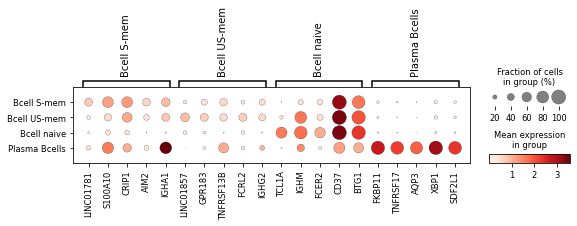

In [25]:
s = 2;imp.reload(lpy)
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Bcells_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )] ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression")

filtered down to 77839 cells


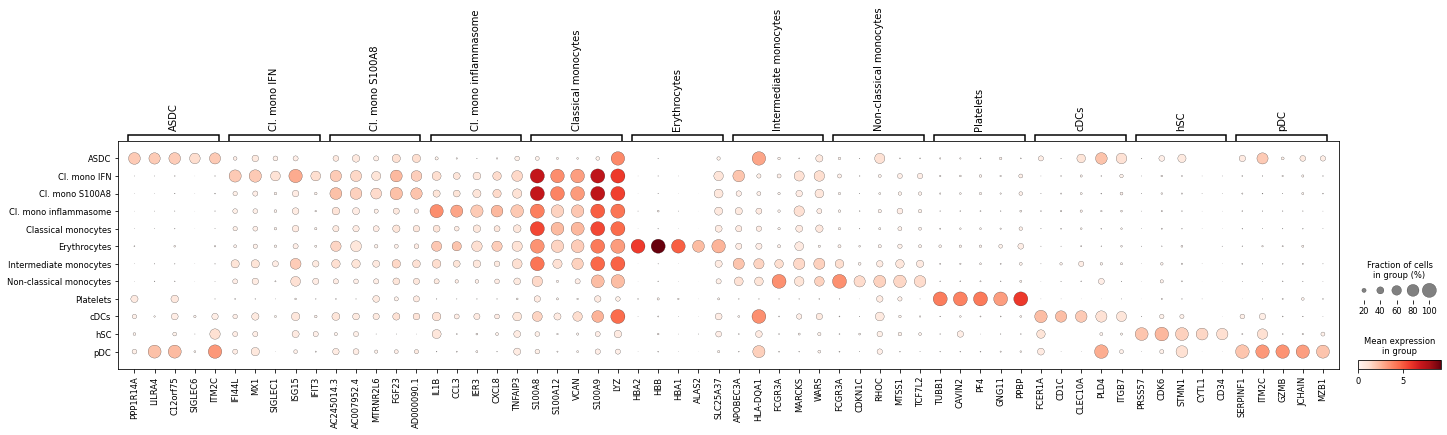

In [26]:
s = 3;
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Monocyte_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )] ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression")

filtered down to 190389 cells


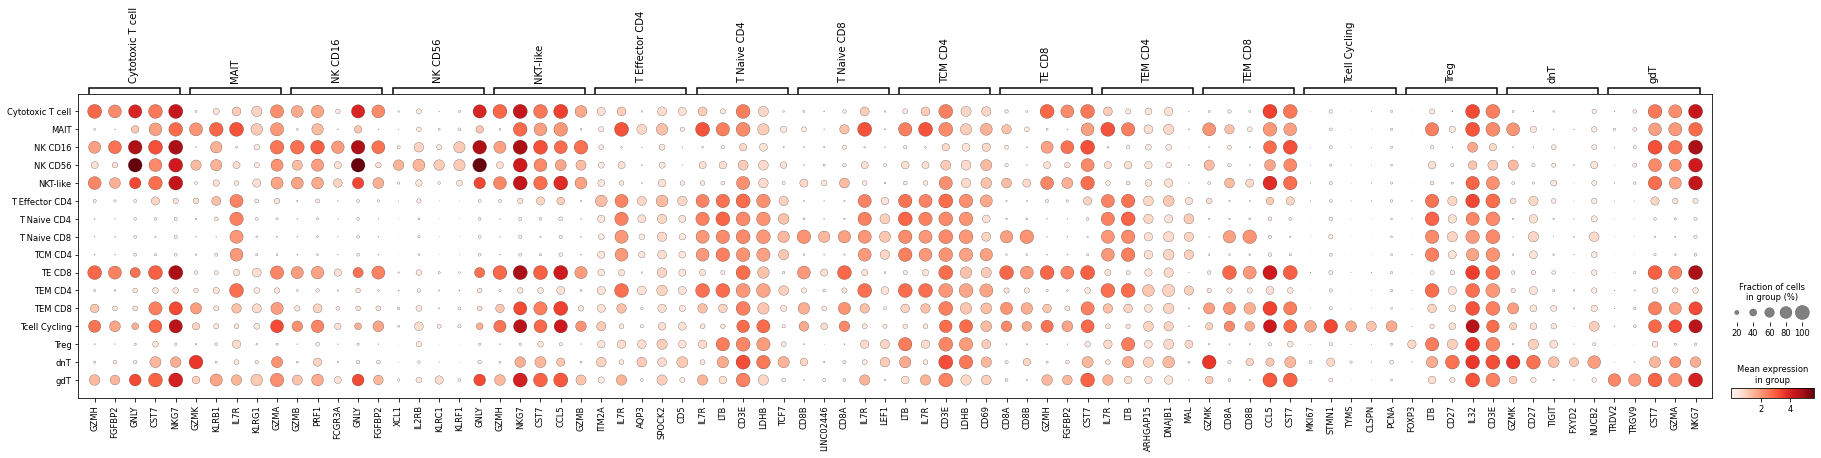

In [27]:
s = 1;imp.reload(lpy)
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Tcells_globaltfidf_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )]  ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression",
                        global_cell_filter =[ (x in filt[0])  for x in adata.obs["broad_integrated"]] 
                        )

filtered down to 22306 cells


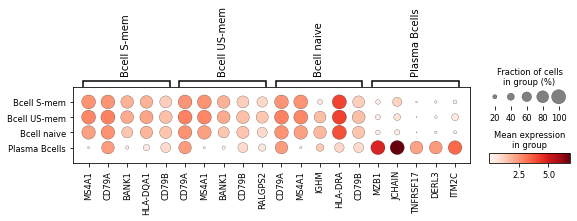

In [28]:
s = 2;
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Bcells_globaltfidf_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )] ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression",
                        global_cell_filter =[ (x in filt[0])  for x in adata.obs["broad_integrated"]] 
                        )

filtered down to 77839 cells


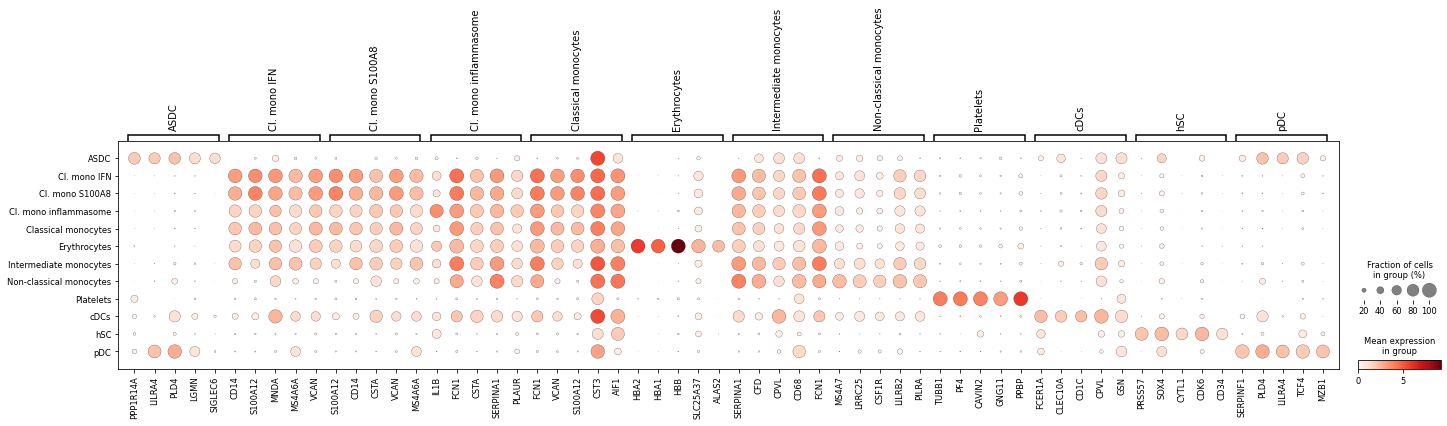

In [29]:
s = 3;
adata = lpy.binarizedDE(adata,"general_integrated2", savepdf="Monocyte_globaltfidf_dotplot.pdf",
                        cell_filter =[ (x in filt[s]) and (y != 'filtered') for x,y in zip(adata.obs["broad_integrated"], adata.obs[annotation[s]] )] ,
                        gene_filter = adata.var["feature_types"] == "Gene Expression",
                        global_cell_filter =[ (x in filt[0])  for x in adata.obs["broad_integrated"]] 
                        )

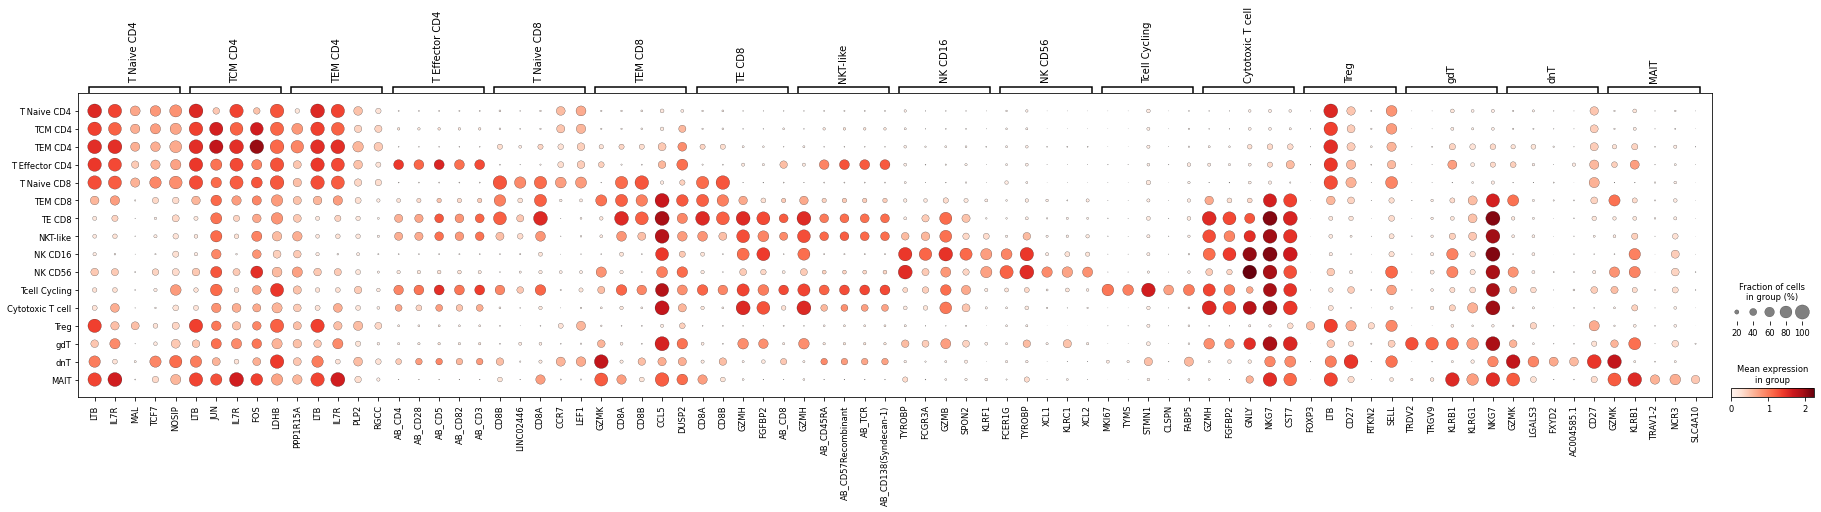

In [30]:
adata_count.uns['rank_genes_groups'] = adata.uns["general_integrated2_rank_markers"]
sc.pl.rank_genes_groups_dotplot(adata_count, n_genes=5, dendrogram=False, save="test.pdf")

In [31]:
mmm.uns["general_integrated2_rank_markers"]

{'params': {'groupby': 'general_integrated2',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('LTB', 'LTB', 'PPP1R15A', 'AB_CD4', 'CD8B', 'GZMK', 'CD8A', 'GZMH', 'TYROBP', 'FCER1G', 'MKI67', 'GZMH', 'FOXP3', 'TRDV2', 'GZMK', 'GZMK'),
            ('IL7R', 'JUN', 'LTB', 'AB_CD28', 'LINC02446', 'CD8A', 'CD8B', 'AB_CD45RA', 'FCGR3A', 'TYROBP', 'TYMS', 'FGFBP2', 'LTB', 'TRGV9', 'LGALS3', 'KLRB1'),
            ('MAL', 'IL7R', 'IL7R', 'AB_CD5', 'CD8A', 'CD8B', 'GZMH', 'AB_CD57Recombinant', 'GZMB', 'XCL1', 'STMN1', 'GNLY', 'CD27', 'KLRB1', 'FXYD2', 'TRAV1-2'),
            ...,
            ('GZMA', 'NKG7', 'RARRES3', 'KLRD1', 'NKG7', 'NOSIP', 'TCF7', 'NOSIP', 'CD3G', 'IL32', 'FAU', 'LTB', 'CCL5', 'MAL', 'FTL', 'GZMB'),
            ('NKG7', 'GZMA', 'H3F3A', 'NKG7', 'GZMA', 'MAL', 'IL7R', 'IL7R', 'IL7R', 'CD3G', 'RPL35A', 'SELL', 'NKG7', 'CD8A', 'RPS21', 'GZMH'),
            ('CST7', 'CST7', 'H3F3B',

In [32]:
adatasub = adata[adata.obs["broad_integrated"] == "Bcell"]
mmm = lpy.binarizedDE(adatasub,"general_integrated2")
adata

View of AnnData object with n_obs × n_vars = 191587 × 33759
    obs: 'souporcell', 'demultiplexed', 'sample_names', 'log2p1_count', 'percent_mito', 'n_genes', 'batch', 'full_clustering', 'initial_clustering', 'patient_id', 'StudyName', 'SampleID', 'Fraction', 'Stage', '10x kit', 'Age', 'Sex', 'SARS-CoV-2', 'Comorbidities', 'Medication', 'scrublet_pred', 'scrublet_local_pred', 'scrublet_score', 'scrublet_cluster_score', 'filtered_cells', 'S_score', 'G2M_score', 'phase', 'leiden_sampl_Hani', 'leidenres2_sampl_Hani', 'leiden_sampl_China', 'leidenres2_sampl_China', 'leiden_sampl', 'leidenres2_sampl', 'sampl_Hani', 'sampl', 'leiden_bcell', 'leidenres2_bcell', 'leiden_mono', 'leidenres2_mono', 'CVID_Series', 'patientID', 'sampl_China', 'leidenres2_sampl_totvi', 'leiden_sampl_totvi', 'totvi', 'general', 'general_China', 'general_Hani', 'prog_FDR', 'prog_logFC', 'prog_spFDR', 'conv_FDR', 'conv_logFC', 'conv_spFDR', 'leiden_totvi_tcells', 'leidenres2_totvi_tcells', 'leidenres3_totvi_tcells', 'l

Trying to set attribute `.obs` of view, copying.


array([[[1.300e+02, 3.530e+02, 3.180e+02],
        [9.000e+02, 2.810e+02, 3.280e+02],
        [6.100e+01, 8.300e+01, 1.130e+02],
        [1.023e+03, 1.823e+03, 1.236e+03],
        [6.800e+01, 9.300e+01, 7.600e+01],
        [2.970e+02, 3.880e+02, 3.060e+02],
        [2.870e+02, 4.930e+02, 2.740e+02],
        [1.020e+02, 1.170e+02, 1.900e+02],
        [6.900e+01, 7.500e+01, 1.000e+02],
        [3.400e+01, 6.200e+01, 7.800e+01]],

       [[1.100e+01, 6.700e+01, 5.400e+01],
        [1.700e+01, 4.000e+00, 3.300e+01],
        [4.000e+00, 1.200e+01, 3.000e+01],
        [9.700e+01, 5.150e+02, 2.070e+02],
        [1.000e+00, 4.000e+00, 3.000e+00],
        [4.250e+02, 6.890e+02, 4.740e+02],
        [1.221e+03, 5.169e+03, 3.092e+03],
        [6.000e+01, 3.290e+02, 1.355e+03],
        [3.550e+02, 7.510e+02, 1.170e+03],
        [3.000e+00, 9.000e+00, 1.300e+01]]])

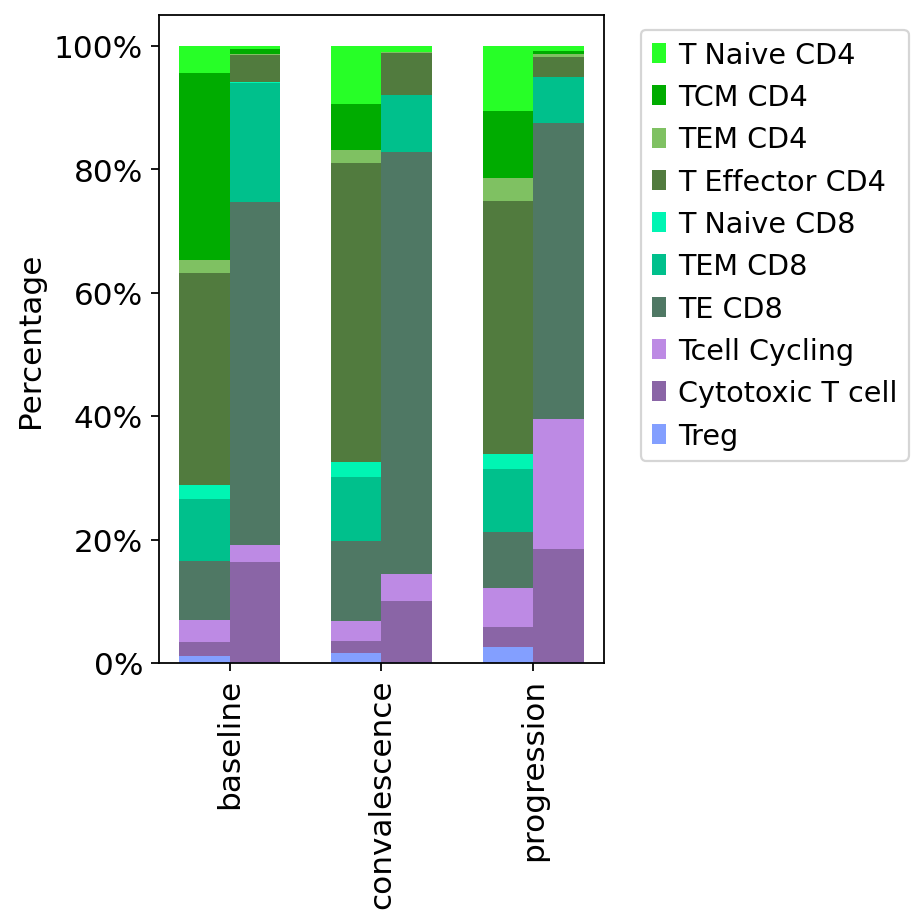

In [33]:
imp.reload(lpy)
flt = (adata.obs["StudyName"] == "Javi")&(adata.obs["clonotype_class"] != "None")&(adata.obs["broad_integrated"] == "Tcell")&([x not in ["NKT-like","NK CD16", "NK CD56", "filtered", "dnT", "MAIT", "gdT"] for x in adata.obs["general_integrated2"]])

adatasub = adata[flt]
adatasub.obs["isExpanded"] =  lpy.applyFactorRename(adatasub.obs["clonotype_class"],{
    "Unique" : "Single",
    tuple(["Post_progression","During_in_progression","Prior_in_progression","Prior_in_convalescense","Prior_in_baseline","During_in_convalescense"]): "Expanded"})
lpy.makeBarplot(adatasub, "general_integrated2", "Stage", "isExpanded",save= "clonotype.pdf")

In [34]:
adata.obs["Stage"] =  lpy.applyFactorRename(adata.obs["Stage"],{
"baseline" : "baseline",
"progression" : "progression",
"convalescence" : "convalescence"
})
adata.obs["Stage"].value_counts(sort = False)

baseline         189297
progression       87991
convalescence     95432
Name: Stage, dtype: int64

In [35]:
adata.obs["Stage"].value_counts(sort = False)

baseline         189297
convalescence     95432
progression       87991
Name: Stage, dtype: int64

In [36]:
flt = (adata.obs["filtered_cells"] == False)&(adata.obs["StudyName"] == "Javi")&(np.random.uniform(size = adata.shape[0]) < 0.5085)
adatasub = adata[flt]
del adatasub.obs
adatasub.write_h5ad("sub.h5ad")
adata.raw[flt].shape

(372720, 33759)

In [37]:
adatasub = anndata.AnnData(adata.raw.X[flt], obs = adatasub.obs, var = adatasub.var)

In [38]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows',12321)
lpy.RTable(adata[(adata.obs["filtered_cells"] == False)&(adata.obs["StudyName"] == "Javi")].obs, "general_integrated", "Azimuth_Hao")
adata.obs.index

,ASDC,B intermediate,B naive,CD14 Mono,CD16 Mono,CD4 CTL,CD4 Naive,CD4 Proliferating,CD4 TCM,CD4 TEM,CD8 Naive,CD8 Proliferating,CD8 TCM,CD8 TEM,Eryth,HSPC,ILC,MAIT,NA,NK,NK Proliferating,NK_CD56bright,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
CD4+ Naive,0,0,0,0,0,0,100,0,895,18,2,0,20,2,4,0,22,0,1039,0,0,0,0,51,0,0,2,0,0
CD4+ TEM,0,0,0,0,0,59,0,0,2496,458,7,0,47,52,13,0,8,5,3162,0,0,0,0,120,0,0,44,1,0
CD8+ Naive,0,0,0,0,0,0,7,0,22,4,132,0,13,3,0,0,0,0,166,0,0,0,0,0,0,0,1,0,0
CD8+ TEM,0,0,0,0,0,441,0,0,13,4,1,2,14,4997,45,0,6,4,5680,239,5,0,0,0,0,0,0,6,0
CD8+ TEMRA,0,0,0,0,0,40,0,0,30,2,173,1,8,5167,27,0,0,1,5616,319,2,0,0,1,0,0,10,54,0
CD8+ TCM,0,0,0,0,0,24,1,0,111,80,4,0,186,2212,15,0,6,7,2546,23,0,0,0,0,0,0,5,15,0
Gamma delta,0,0,0,0,0,16,0,0,3,12,0,0,1,144,8,0,1,26,284,19,0,2,0,0,0,0,0,47,0
NK CD56,0,0,0,0,0,1,0,0,0,0,0,0,0,26,2,0,31,0,576,312,0,191,0,0,0,0,0,1,0
NK CD16,0,0,0,0,0,0,0,0,0,0,0,0,0,72,3,0,0,0,311,260,3,0,0,0,0,0,0,0,0
Cycling Lymphocytes,0,0,0,1,0,2,0,178,111,0,124,418,0,109,7,0,0,0,1429,3,602,0,0,0,0,0,13,0,1


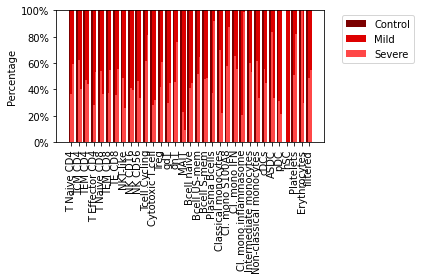

In [39]:
val = lpy.makeBarplot(adata[adata.obs["StudyName"] == "China"].obs, "CovidSeverity", "general_integrated2","Stage") 

array([[[1.2060e+04, 8.8700e+02, 3.6400e+02, 9.8600e+02, 1.6470e+03,
         3.2850e+03, 2.3200e+03, 6.4100e+02, 5.7290e+03, 4.8000e+02,
         1.5600e+02, 1.4320e+03, 1.0220e+03, 1.7670e+03, 8.4000e+01,
         5.6400e+02, 1.9270e+03, 5.6900e+02, 6.8200e+02, 8.8000e+01,
         6.5020e+03, 9.2300e+02, 2.4100e+02, 1.2300e+02, 7.6900e+02,
         1.5030e+03, 5.6400e+02, 9.0000e+00, 1.2400e+02, 0.0000e+00,
         1.6000e+02, 1.2000e+01, 8.9700e+02],
        [1.0547e+04, 8.6470e+03, 1.0805e+04, 8.8300e+02, 5.0430e+03,
         3.9230e+03, 3.7910e+03, 2.3070e+03, 1.0859e+04, 2.5690e+03,
         2.0600e+02, 1.4260e+03, 9.6900e+02, 3.2680e+03, 4.0000e+01,
         1.9450e+03, 4.3620e+03, 1.9540e+03, 1.1960e+03, 9.4000e+01,
         5.0830e+03, 4.3200e+02, 2.0900e+02, 3.4030e+03, 9.7600e+02,
         3.1900e+03, 1.9970e+03, 1.7000e+01, 6.6100e+02, 1.1100e+02,
         2.8500e+02, 6.3000e+01, 4.2870e+03],
        [1.7400e+02, 1.3490e+03, 8.1000e+01, 1.2030e+03, 1.0000e+02,
         9.

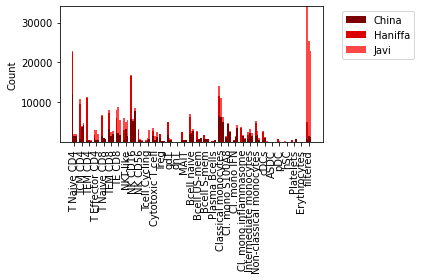

In [40]:
lpy.makeBarplot(adata.obs, "StudyName", "general_integrated2","Stage",makeProportion=False) 

[-4.80591449  2.72811621]
[-4.86049276 -0.16207794]
[-1.19953056 -1.46523415]
[-1.13713253  2.15441928]
[-9.5115578  -1.38653248]
[5.29928251 1.72079395]
[8.81892114 3.68573732]
[10.20599234  1.18415239]
[16.6861483 -1.1727256]
[16.69042447 -4.74015686]
[ 9.1981487  10.35201506]
[ 8.97969436 -0.76971379]
[-2.85778061  4.75067533]
[ 7.20185854 -3.3590069 ]
[1.55548086 6.06158554]
[ 3.27219909 -4.0557792 ]


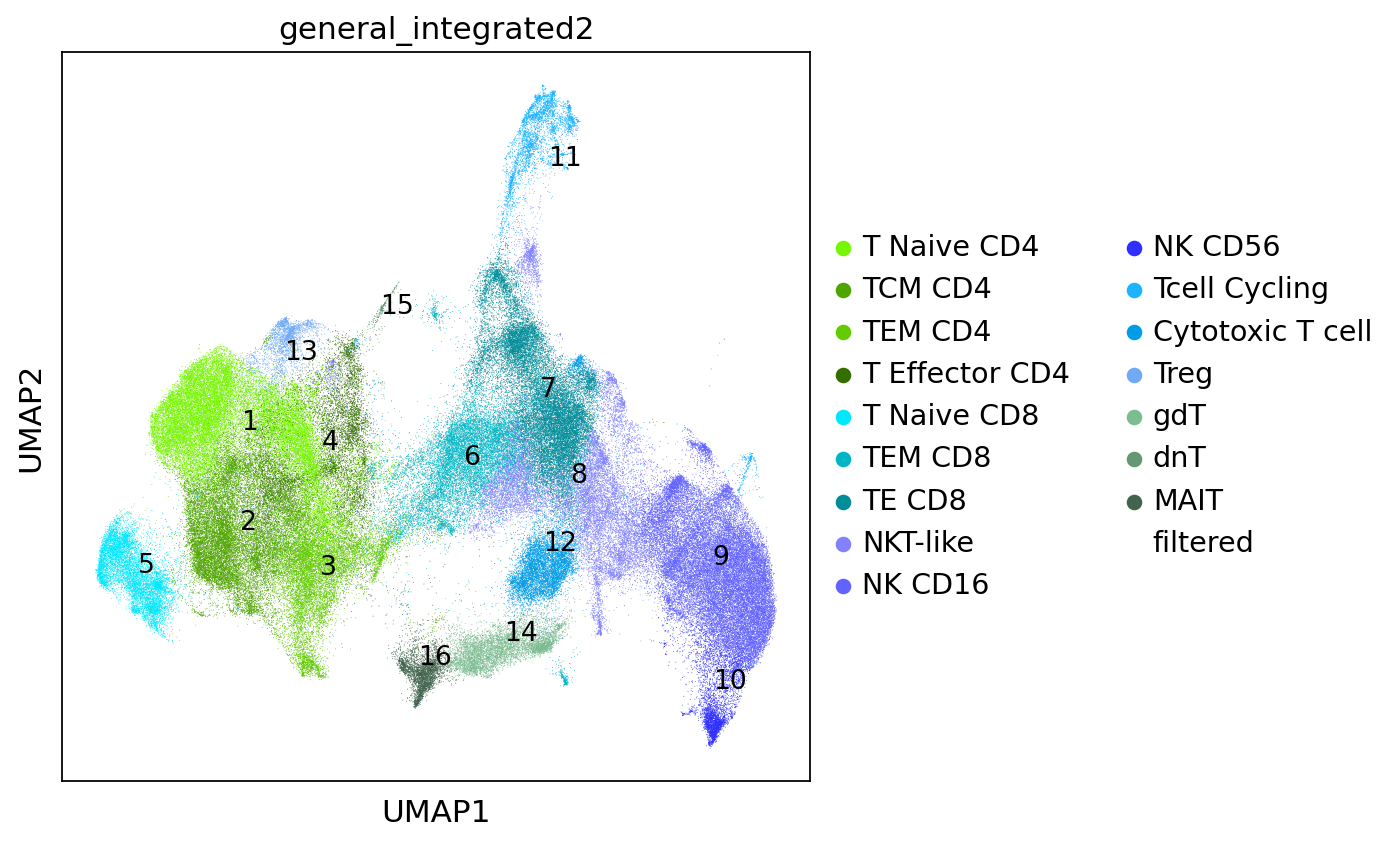

In [41]:
adatasub = adata[adata.obs["broad_integrated"] == "Tcell"]
adatasub.obsm["umap"] = adatasub.obsm["X_umap_every_tcell20unpool"]
sc.set_figure_params(figsize= [6,6], vector_friendly=True)
fig, ax = plt.subplots()
dico= ["T Naive CD4","TCM CD4","TEM CD4","T Effector CD4","T Naive CD8","TEM CD8","TE CD8",'NKT-like', 'NK CD16', 'NK CD56', 'Tcell Cycling',
       'Cytotoxic T cell', 'Treg', 'gdT', 'dnT', 'MAIT']
for i in range(len(dico)):
    center = np.nanmean(adatasub.obsm["umap"][np.array(adatasub.obs["general_integrated2"] == dico[i]),],axis=0)
    print(center)
    ax.text(center[0],center[1],str(chr(97+i)), {"size":12})

sc.pl.umap(adatasub, color="general_integrated2",save= "tcells_2.pdf",ax=ax)


[-1.16541603 -7.60360275]
[ 0.1331449  -6.85819871]
[-0.55222142 -3.99868449]
[-2.50513647 -4.90456866]
[  2.89380218 -10.04184978]
[-3.81442402  1.46019894]
[-6.4831095   3.06295452]
[-5.24597831  4.37835549]
[-3.50854425  9.35178923]
[-2.6495026  12.14637872]
[2.27638342 7.60243066]
[-7.74497284  1.60916873]
[-2.90196864 -6.71811104]
[-0.76238733  2.67543736]
[-2.9315181  -1.00428089]
[0.4919929  0.01532424]
[ 9.18256261 17.4705592 ]
[ 9.0004978  15.64217478]
[ 9.70814124 15.34387692]
[9.30204669 9.33700725]
[14.48554087 -0.71223027]
[12.7397647  -2.48316448]
[14.84088383 -0.95542035]
[14.7675982  -4.86646664]
[16.48605263 -1.91589126]
[18.9187264 -4.6991831]
[15.21441943  5.09002022]
[15.14302486  6.54350071]
[16.12710246 11.81843151]
[12.60332937 10.4336191 ]
[ 10.54067084 -15.4057246 ]
[16.90963968  4.18288222]


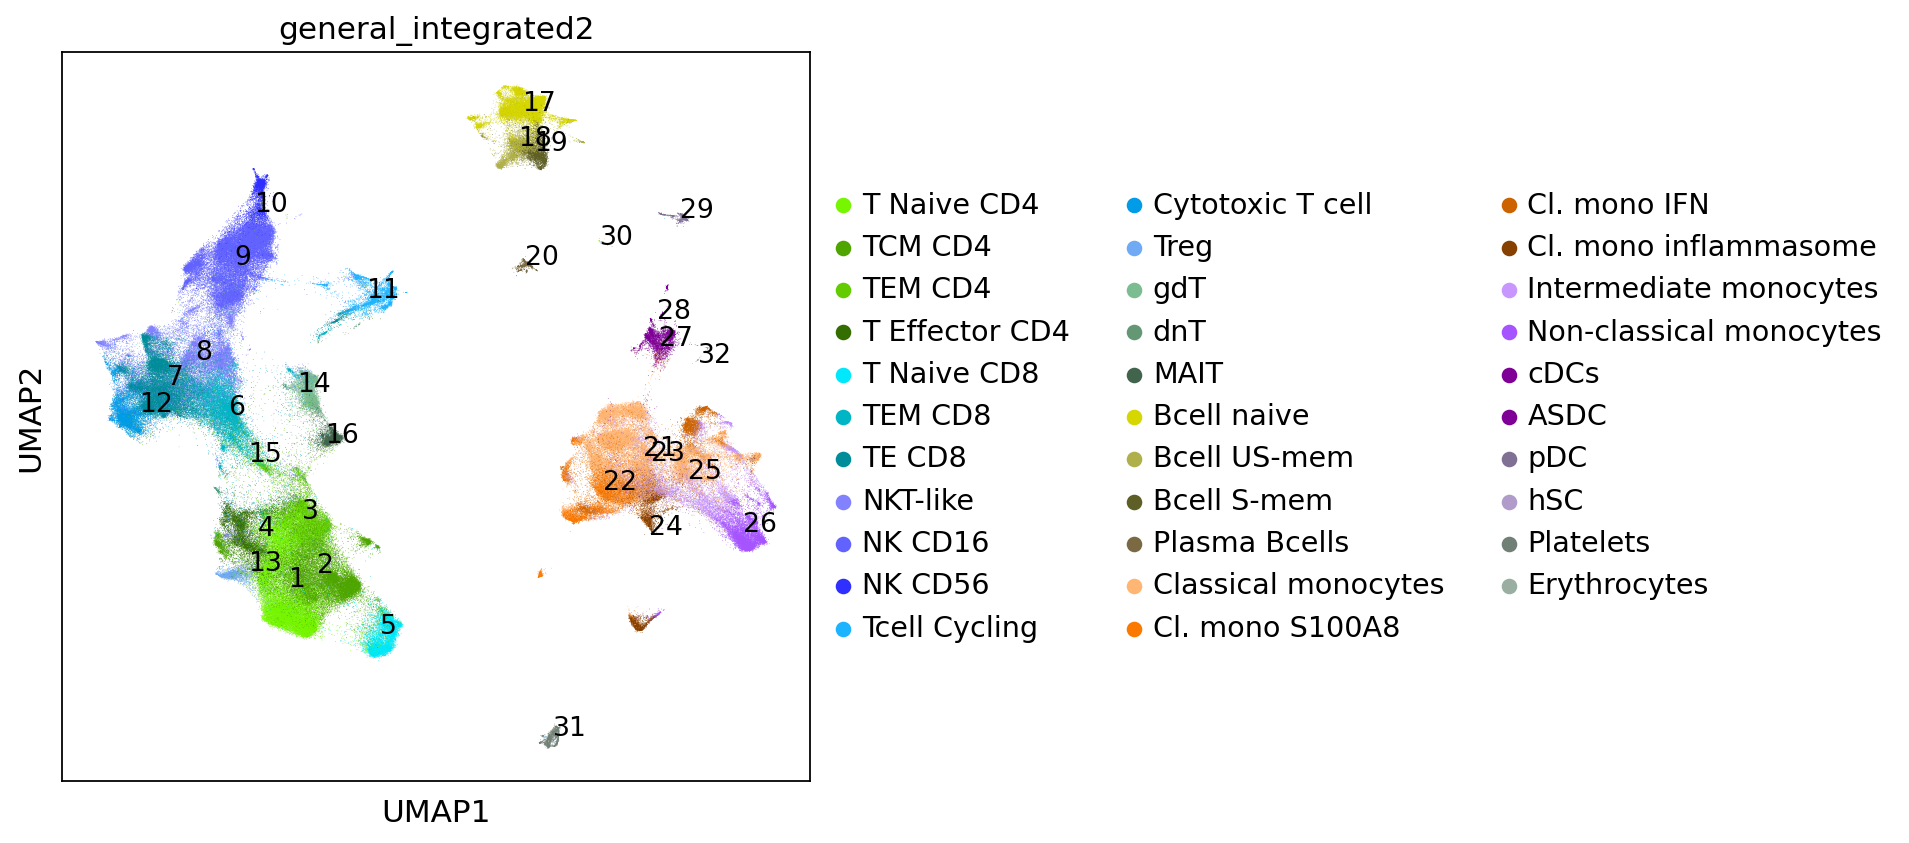

In [42]:
adatasub = adata[adata.obs["general_integrated2"] != "filtered"]
adatasub.obsm["umap"] = adatasub.obsm["X_umap_everything_unpool"]
sc.set_figure_params(figsize= [6,6], vector_friendly=True)

fig, ax = plt.subplots()
dico= ['T Naive CD4', 'TCM CD4', 'TEM CD4', 'T Effector CD4', 'T Naive CD8',
       'TEM CD8', 'TE CD8', 'NKT-like', 'NK CD16', 'NK CD56', 'Tcell Cycling',
       'Cytotoxic T cell', 'Treg', 'gdT', 'dnT', 'MAIT', 'Bcell naive',
       'Bcell US-mem', 'Bcell S-mem', 'Plasma Bcells', 'Classical monocytes',
       'Cl. mono S100A8', 'Cl. mono IFN', 'Cl. mono inflammasome',
       'Intermediate monocytes', 'Non-classical monocytes', 'cDCs', 'ASDC',
       'pDC', 'hSC', 'Platelets', 'Erythrocytes']
for i in range(len(dico)):
    center = np.nanmean(adatasub.obsm["umap"][np.array(adatasub.obs["general_integrated2"] == dico[i]),],axis=0)
    print(center)
    ax.text(center[0],center[1],str(i+1), {"size":12})

sc.pl.umap(adatasub, color="general_integrated2",save= "general3.pdf",ax=ax)